<a href="https://colab.research.google.com/github/YB-Sung/DXIC_Lab_12_DL3_/blob/main/Vanilla_RNN_LSTM_GRU_for_Time_series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [ LG전자 H&A DX Intensive Course - RNN/LSTM/GRU for Time-series ]

**Task**: time-series forecasting

In [ ]:
import os
import json
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
def torch_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

# Dataset

## Download

ETTh dataset

https://github.com/zhouhaoyi/ETDataset

In [ ]:
!wget https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv

--2024-03-20 13:00:24--  https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2589657 (2.5M) [text/plain]
Saving to: ‘ETTh1.csv.2’

ETTh1.csv.2         100%[===================>]   2.47M  --.-KB/s    in 0.03s   

2024-03-20 13:00:24 (98.1 MB/s) - ‘ETTh1.csv.2’ saved [2589657/2589657]

--2024-03-20 13:23:55--  https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2589657 (2.5M) [text/pla

## Load Dataset

학습을 위해 구성할 데이터 구조

<p align="center">
  <img src="https://github.com/TooTouch/BalancedSoftmax/assets/37654013/4ef4be72-13fd-4602-a397-580f2bea305d">
</p>



In [ ]:
df = pd.read_csv('ETTh1.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

In [ ]:
df

date    HUFL   HULL   MUFL   MULL   LUFL   LULL  \
0     2016-07-01 00:00:00   5.827  2.009  1.599  0.462  4.203  1.340   
1     2016-07-01 01:00:00   5.693  2.076  1.492  0.426  4.142  1.371   
2     2016-07-01 02:00:00   5.157  1.741  1.279  0.355  3.777  1.218   
3     2016-07-01 03:00:00   5.090  1.942  1.279  0.391  3.807  1.279   
4     2016-07-01 04:00:00   5.358  1.942  1.492  0.462  3.868  1.279   
...                   ...     ...    ...    ...    ...    ...    ...   
17415 2018-06-26 15:00:00  -1.674  3.550 -5.615  2.132  3.472  1.523   
17416 2018-06-26 16:00:00  -5.492  4.287 -9.132  2.274  3.533  1.675   
17417 2018-06-26 17:00:00   2.813  3.818 -0.817  2.097  3.716  1.523   
17418 2018-06-26 18:00:00   9.243  3.818  5.472  2.097  3.655  1.432   
17419 2018-06-26 19:00:00  10.114  3.550  6.183  1.564  3.716  1.462   

              OT  
0      30.531000  
1      27.787001  
2      27.787001  
3      25.044001  
4      21.948000  
...          ...  
17415  10.904000  
17416  11.044000  
17417  10.271000  
17418   9.778000  
17419   9.567000  

[17420 rows x 8 columns]

date    HUFL   HULL   MUFL   MULL   LUFL   LULL  \
0     2016-07-01 00:00:00   5.827  2.009  1.599  0.462  4.203  1.340   
1     2016-07-01 01:00:00   5.693  2.076  1.492  0.426  4.142  1.371   
2     2016-07-01 02:00:00   5.157  1.741  1.279  0.355  3.777  1.218   
3     2016-07-01 03:00:00   5.090  1.942  1.279  0.391  3.807  1.279   
4     2016-07-01 04:00:00   5.358  1.942  1.492  0.462  3.868  1.279   
...                   ...     ...    ...    ...    ...    ...    ...   
17415 2018-06-26 15:00:00  -1.674  3.550 -5.615  2.132  3.472  1.523   
17416 2018-06-26 16:00:00  -5.492  4.287 -9.132  2.274  3.533  1.675   
17417 2018-06-26 17:00:00   2.813  3.818 -0.817  2.097  3.716  1.523   
17418 2018-06-26 18:00:00   9.243  3.818  5.472  2.097  3.655  1.432   
17419 2018-06-26 19:00:00  10.114  3.550  6.183  1.564  3.716  1.462   

              OT  
0      30.531000  
1      27.787001  
2      27.787001  
3      25.044001  
4      21.948000  
...          ...  
17415  10.904000  
17416  11.044000  
17417  10.271000  
17418   9.778000  
17419   9.567000  

[17420 rows x 8 columns]

In [ ]:
X = df.values[:,1:-1]
y = df.values[:,-1]

print('X.shape: ',X.shape)
print('y.shape: ',y.shape)

X.shape:  (17420, 6)
y.shape:  (17420,)
X.shape:  (17420, 6)
y.shape:  (17420,)


In [ ]:
window_size = 24 * 4 # 4 days
forecasting_size = 24 * 4 # 4 days
stride = 1
nb_samples = len(X)
nb_window = (nb_samples - (window_size + forecasting_size)) + stride

print('window_size: ',window_size)
print('forecasting_size: ',forecasting_size)
print('stride: ',stride)
print('nb_samples: {:,}'.format(nb_samples))
print('nb_window: {:,}'.format(nb_window))

window_size:  96
forecasting_size:  96
stride:  1
nb_samples: 17,420
nb_window: 17,229
window_size:  96
forecasting_size:  96
stride:  1
nb_samples: 17,420
nb_window: 17,229


In [ ]:
window_idx = np.arange(nb_window)

In [ ]:
test_len = 24 * 120
valid_len = 24 * 120

test_window_idx = window_idx[-test_len:]
valid_window_idx = window_idx[-(test_len + valid_len):-test_len]
train_window_idx = window_idx[:-(test_len + valid_len)]

print('train_window_idx.shape: ', train_window_idx.shape)
print('valid_window_idx.shape: ', valid_window_idx.shape)
print('test_window_idx.shape: ', test_window_idx.shape)

train_window_idx.shape:  (11469,)
valid_window_idx.shape:  (2880,)
test_window_idx.shape:  (2880,)
train_window_idx.shape:  (11469,)
valid_window_idx.shape:  (2880,)
test_window_idx.shape:  (2880,)


# Create Dataset and DataLoader

In [ ]:
X_scaler = StandardScaler()
X_scaler.fit(X[:-(valid_len+test_len)])

y_scaler = StandardScaler()
y_scaler.fit(y[:-(valid_len+test_len)].reshape(-1,1))

StandardScaler()

StandardScaler()

In [ ]:
class TSDataset(Dataset):
    def __init__(
        self,
        X,
        y,
        window_idx: np.ndarray,
        window_size: int,
        forecasting_size: int,
        X_scaler,
        y_scaler
      ):
        self.X = X
        self.y = y
        self.window_idx = window_idx
        self.window_size = window_size
        self.forecasting_size = forecasting_size

        self.X_scaler = X_scaler
        self.y_scaler = y_scaler

    def __getitem__(self, i):
        selected_idx = self.window_idx[i]

        window = np.arange(self.window_size) + selected_idx
        forecasting_window = np.arange(self.window_size + self.forecasting_size) + selected_idx

        x_enc = self.X[window].astype(np.float32)
        y_i = self.y[forecasting_window].astype(np.float32)

        # scaling
        x_enc = self.X_scaler.transform(x_enc)
        y_i = self.y_scaler.transform(y_i.reshape(-1,1))

        x_enc = np.c_[x_enc, y_i[:self.window_size]]
        x_dec = y_i[self.window_size-1:-1]

        target = y_i[self.window_size:]

        return x_enc, x_dec, target

    def __len__(self):
        return len(self.window_idx)

In [ ]:
trainset = TSDataset(
    X                = X,
    y                = y,
    window_idx       = train_window_idx,
    window_size      = window_size,
    forecasting_size = forecasting_size,
    X_scaler         = X_scaler,
    y_scaler         = y_scaler
)

validset = TSDataset(
    X                = X,
    y                = y,
    window_idx       = valid_window_idx,
    window_size      = window_size,
    forecasting_size = forecasting_size,
    X_scaler         = X_scaler,
    y_scaler         = y_scaler
)

testset = TSDataset(
    X                = X,
    y                = y,
    window_idx       = test_window_idx,
    window_size      = window_size,
    forecasting_size = forecasting_size,
    X_scaler         = X_scaler,
    y_scaler         = y_scaler
)

In [ ]:
x_enc_temp, x_dec_temp, targets_temp = trainset[5]

print('x_enc_temp.shape: ',x_enc_temp.shape)
print('x_dec_temp.shape: ',x_dec_temp.shape)
print('targets_temp.shape: ',targets_temp.shape)

x_enc_temp.shape:  (96, 7)
x_dec_temp.shape:  (96, 1)
targets_temp.shape:  (96, 1)
x_enc_temp.shape:  (96, 7)
x_dec_temp.shape:  (96, 1)
targets_temp.shape:  (96, 1)


In [ ]:
trainloader = DataLoader(
    dataset     = trainset,
    batch_size  = 128,
    shuffle     = True,
)

validloader = DataLoader(
    dataset     = validset,
    batch_size  = 1024,
    shuffle     = False,
)

testloader = DataLoader(
    dataset     = testset,
    batch_size  = 1024,
    shuffle     = False,
)

In [ ]:
inputs_enc, inputs_dec, targets = next(iter(trainloader))
print('inputs_enc.shape: ', inputs_enc.shape)
print('inputs_dec.shape: ', inputs_dec.shape)
print('targets.shape: ', targets.shape)

inputs_enc.shape:  torch.Size([128, 96, 7])
inputs_dec.shape:  torch.Size([128, 96, 1])
targets.shape:  torch.Size([128, 96, 1])
inputs_enc.shape:  torch.Size([128, 96, 7])
inputs_dec.shape:  torch.Size([128, 96, 1])
targets.shape:  torch.Size([128, 96, 1])


# Build Model

Many-to-Many 방법

<p align="center">
  <img src="https://github.com/TooTouch/BalancedSoftmax/assets/37654013/7cf196d2-41a6-43a8-a563-6d255e01626d">
</p>



In [ ]:
class VanillaModel(nn.Module):
    def __init__(self, module_type: str, input_dim: int, hidden_dim: int, num_layers: int):
        super(VanillaModel, self).__init__()

        # check module type
        self.module_type = module_type
        module_list = ['RNN', 'LSTM', 'GRU']
        assert self.module_type in module_list, 'module_type is not in {}'.format(module_list)

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.encoder = getattr(nn, module_type)(
            input_size  = input_dim,
            hidden_size = hidden_dim,
            num_layers  = num_layers,
            batch_first = True
          )

        self.decoder = getattr(nn, module_type)(
            input_size  = 1,
            hidden_size = hidden_dim,
            num_layers  = num_layers,
            batch_first = True
          )

        self.clf = nn.Linear(in_features=hidden_dim, out_features=1)

    def encode(self, x):
        bs, _, _ = x.shape # (batch size x time length(sequence) x features)

        # Initialize hidden and cell states (num_layers x batch size x dim)
        h0 = torch.zeros(self.num_layers, bs, self.hidden_dim, device=x.device)

        if self.module_type == 'LSTM':
          c0 = torch.zeros(self.num_layers, bs, self.hidden_dim, device=x.device)
          states = (h0, c0)
        elif self.module_type in ['RNN', 'GRU']:
          states = h0

        # encoding
        out, states = self.encoder(x, states)

        return out, states

    def decode(self, x, encoder_states):

        out, states = self.decoder(x, encoder_states)
        out = self.clf(out)

        return out, states

    def infer(self, x, forecasting_size):
        with torch.no_grad():
            out, states = self.encode(x=x)

            preds = []
            x_dec = x[:,-1,-1].reshape(-1, 1, 1)

            for i in range(forecasting_size):
                out, states = self.decode(x_dec, encoder_states=states)
                preds.append(out)

                x_dec = out

        preds = torch.cat(preds, dim=1)

        return preds

    def forward(self, x_enc, x_dec):
        # encoding
        out, states = self.encode(x=x_enc)

        # decoding
        out, _ = self.decode(x=x_dec, encoder_states=states)

        return out

In [ ]:
# Instantiate the RNN model
model_rnn = VanillaModel(module_type='RNN', input_dim=X.shape[1]+1, hidden_dim=32, num_layers=2)
model_rnn

VanillaModel(
  (encoder): RNN(7, 32, num_layers=2, batch_first=True)
  (decoder): RNN(1, 32, num_layers=2, batch_first=True)
  (clf): Linear(in_features=32, out_features=1, bias=True)
)

VanillaModel(
  (encoder): RNN(7, 32, num_layers=2, batch_first=True)
  (decoder): RNN(1, 32, num_layers=2, batch_first=True)
  (clf): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
outputs = model_rnn(x_enc=inputs_enc, x_dec=inputs_dec)
print('outputs.shape: ',outputs.shape)

outputs.shape:  torch.Size([128, 96, 1])
outputs.shape:  torch.Size([128, 96, 1])


In [ ]:
preds = model_rnn.infer(x=inputs_enc, forecasting_size=10)
print('preds.shape: ',preds.shape)

preds.shape:  torch.Size([128, 10, 1])
preds.shape:  torch.Size([128, 10, 1])


In [ ]:
preds = model_rnn.infer(x=inputs_enc, forecasting_size=20)
print('preds.shape: ',preds.shape)

preds.shape:  torch.Size([128, 20, 1])
preds.shape:  torch.Size([128, 20, 1])


# Training Model

In [ ]:
def calc_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    return {
        "RMSE" : rmse,
        "MAE"  : mae,
    }

def train(model, trainloader, optimizer, criterion, scaler):
    # train mode
    model.train()

    # device
    device = next(iter(model.parameters())).device

    # results
    all_outputs = []
    all_targets = []
    total_loss = 0

    # progress
    pbar = tqdm(trainloader, total=len(trainloader), desc="[TRAIN]", leave=False)

    # training
    for batch_i, batch in enumerate(pbar):
        inputs_enc, inputs_dec, targets = batch

        # device
        inputs_enc, inputs_dec, targets = inputs_enc.to(device), inputs_dec.to(device), targets.to(device)

        # outputs
        outputs = model(x_enc=inputs_enc, x_dec=inputs_dec)

        # loss
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # compute gradients
        loss.backward()

        # update model parameters using optimizer
        optimizer.step()
        optimizer.zero_grad()

        # stack outputs and targets
        all_outputs.extend(outputs.detach().cpu().tolist())
        all_targets.extend(targets.detach().cpu().tolist())

        # update progress
        pbar.set_description(desc="[TRAIN]: Loss: {loss:7.4f} ({loss_avg:7.4f})".format(
            loss     = loss,
            loss_avg = total_loss / (batch_i+1),
        ))

    all_outputs = np.asarray(all_outputs)[:,:,0]
    all_targets = np.asarray(all_targets)[:,:,0]

    # inverse transform
    all_outputs = scaler.inverse_transform(all_outputs)
    all_targets = scaler.inverse_transform(all_targets)

    results = calc_metrics(y_true=all_targets, y_pred=all_outputs)

    return results

def test(model, testloader, criterion, scaler, forecasting_size: int, return_preds: bool = False):
    # evaluation mode
    model.eval()

    # device
    device = next(iter(model.parameters())).device

    # results
    all_outputs = []
    all_targets = []
    total_loss = 0

    # progress
    pbar = tqdm(testloader, total=len(testloader), desc="[TEST]", leave=False)

    # evaluation
    with torch.no_grad():
        for batch_i, batch in enumerate(pbar):
            inputs_enc, inputs_dec, targets = batch

            # device
            inputs_enc, inputs_dec, targets = inputs_enc.to(device), inputs_dec.to(device), targets.to(device)

            # outputs
            outputs = model.infer(x=inputs_enc, forecasting_size=forecasting_size)

            # loss
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # stack outputs and targets
            all_outputs.extend(outputs.cpu().tolist())
            all_targets.extend(targets.cpu().tolist())


            # update progress
            pbar.set_description(desc="[TEST]: Loss: {loss:7.4f} ({loss_avg:7.4f})".format(
                loss     = loss,
                loss_avg = total_loss / (batch_i+1),
            ))

    all_outputs = np.asarray(all_outputs)[:,:,0]
    all_targets = np.asarray(all_targets)[:,:,0]

    # inverse transform
    all_outputs = scaler.inverse_transform(all_outputs)
    all_targets = scaler.inverse_transform(all_targets)

    results = calc_metrics(y_true=all_targets, y_pred=all_outputs)

    if return_preds:
        return results, all_outputs
    else:
        return results

def fit(model, epochs, trainloader, testloader, criterion, optimizer, scheduler, forecasting_size: int, scaler, savedir: str, seed: int = 223):
    torch_seed(seed)

    # make save directory
    os.makedirs(savedir, exist_ok=True)

    # history
    history = {'train': defaultdict(list), 'test': defaultdict(list)}
    best_rmse = np.inf

    # progress bar
    pbar = tqdm(range(epochs), total=epochs)
    for i in pbar:

        # train
        train_results = train(
            model       = model,
            trainloader = trainloader,
            criterion   = criterion,
            optimizer   = optimizer,
            scaler      = scaler
        )

        # test
        test_results = test(
            model            = model,
            testloader       = testloader,
            criterion        = criterion,
            forecasting_size = forecasting_size,
            scaler           = scaler
        )

        # update scheduler
        scheduler.step()

        # update progress
        pbar.set_description(desc="[TRAIN] RMSE: {rmse_train:>7.4f} [TEST] RMSE: {rmse_test:>7.4f}".format(
            rmse_train = train_results['RMSE'],
            rmse_test  = test_results['RMSE']
        ))

        # append history
        for k, v in train_results.items():
            history['train'][k].append(v)

        for k, v in test_results.items():
            history['test'][k].append(v)

        # save best model
        if best_rmse > test_results['RMSE']:
            torch.save(model.state_dict(), os.path.join(savedir, 'best_model.pt'))

    # save results
    json.dump(history, open(os.path.join(savedir, 'history.json'), 'w'), indent='\t')

    return history

def history_plot(history: dict):
    # train history table
    df_train_history = pd.DataFrame(history['train'])
    df_train_history['epoch'] = range(len(df_train_history))
    df_train_history['split'] = 'train'

    # test history table
    df_test_history = pd.DataFrame(history['test'])
    df_test_history['epoch'] = range(len(df_test_history))
    df_test_history['split'] = 'test'
    df_history = pd.concat([df_train_history, df_test_history], axis=0)

    # plot
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    for i, m in enumerate(['RMSE', 'MAE']):
        sns.lineplot(
            x    = 'epoch',
            y    = m,
            hue  = 'split',
            data = df_history,
            ax   = ax[i]
        )
        ax[i].set_ylabel(m.upper())
    plt.tight_layout()
    plt.show()

In [ ]:
epochs = 20
lr = 1e-2
eta_min = lr * 1e-2
seed = 223

In [ ]:
# Instantiate the RNN model
torch_seed(223)
model_rnn = VanillaModel(module_type='RNN', input_dim=X.shape[1]+1, hidden_dim=256, num_layers=2)
model_lstm = VanillaModel(module_type='LSTM', input_dim=X.shape[1]+1, hidden_dim=256, num_layers=2)
model_gru = VanillaModel(module_type='GRU', input_dim=X.shape[1]+1, hidden_dim=256, num_layers=2)

print('RNN parameters: {:,}'.format(sum([p.numel() for p in model_rnn.parameters()])))
print('LSTM parameters: {:,}'.format(sum([p.numel() for p in model_lstm.parameters()])))
print('GRU parameters: {:,}'.format(sum([p.numel() for p in model_gru.parameters()])))

model_rnn.cuda()
model_lstm.cuda()
model_gru.cuda()
print('convert device to GPU')

RNN parameters: 397,569
LSTM parameters: 1,589,505
GRU parameters: 1,192,193
convert device to GPU
RNN parameters: 397,569
LSTM parameters: 1,589,505
GRU parameters: 1,192,193
convert device to GPU


In [ ]:
# optimizer
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=lr)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=lr)
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=lr)

scheduler_rnn = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_rnn, T_max=epochs, eta_min=eta_min)
scheduler_lstm = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_lstm, T_max=epochs, eta_min=eta_min)
scheduler_gru = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_gru, T_max=epochs, eta_min=eta_min)

# loss function
criterion = nn.MSELoss()

RNN


  0%|          | 0/20 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

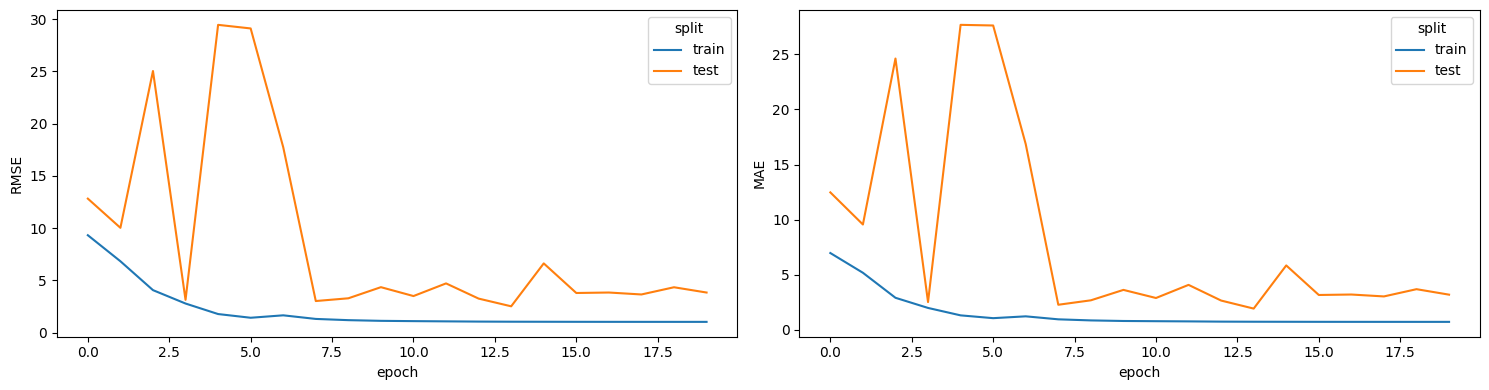

LSTM


  0%|          | 0/20 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

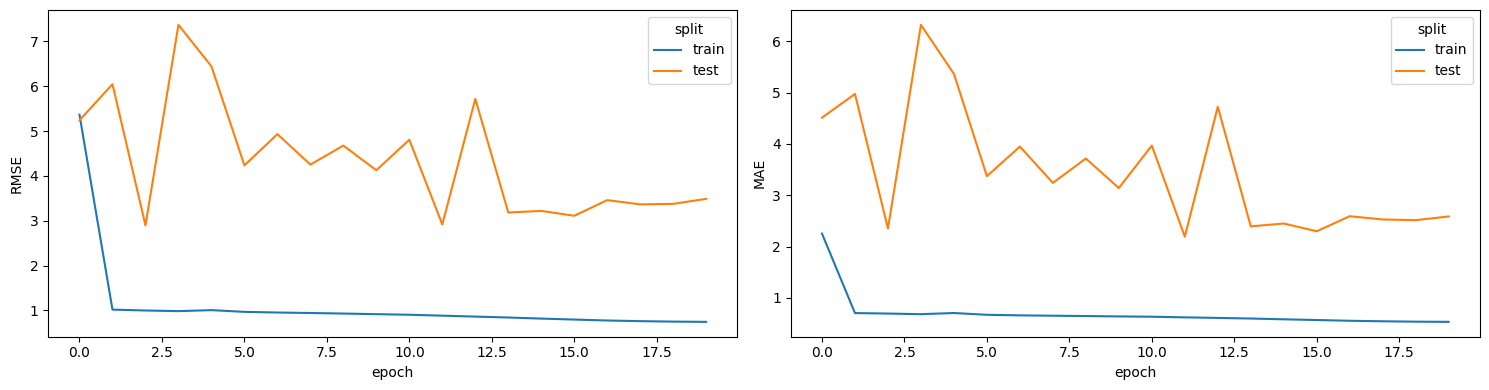

GRU


  0%|          | 0/20 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

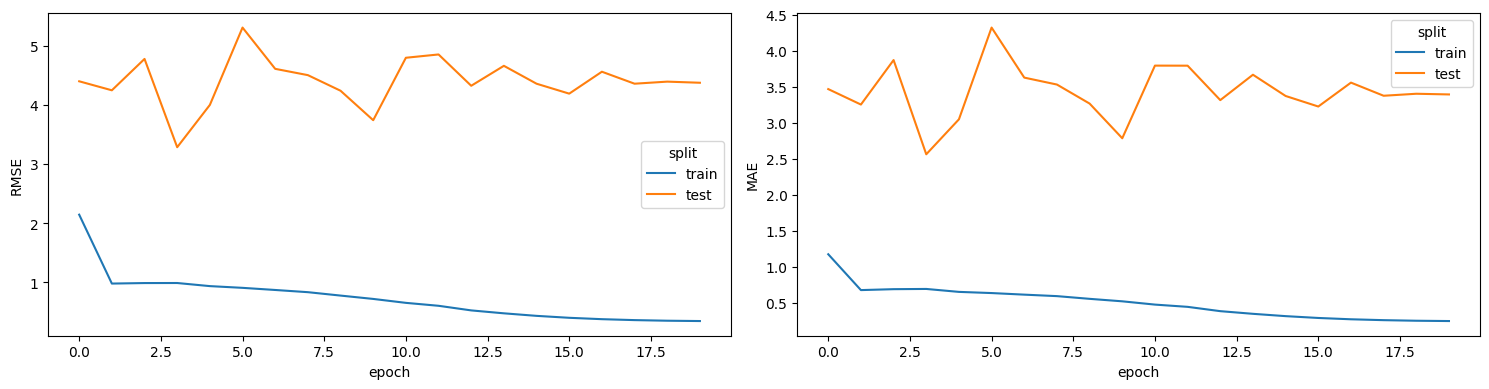

RNN


  0%|          | 0/20 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

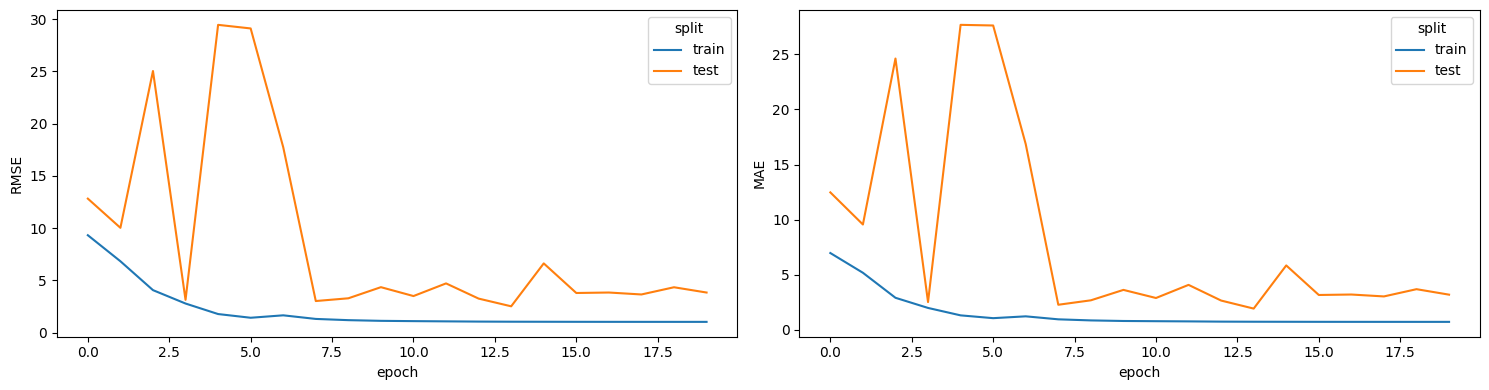

LSTM


  0%|          | 0/20 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

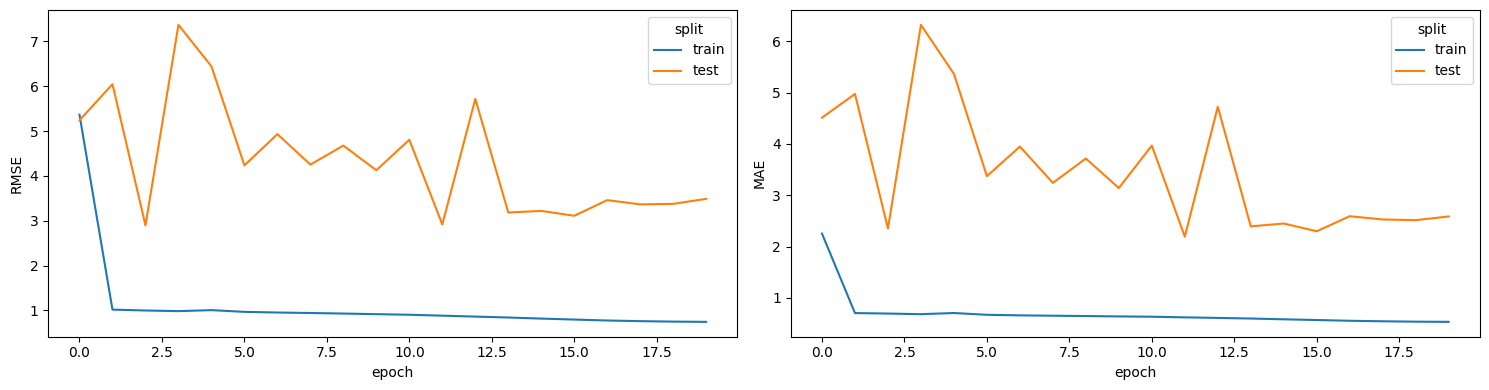

GRU


  0%|          | 0/20 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

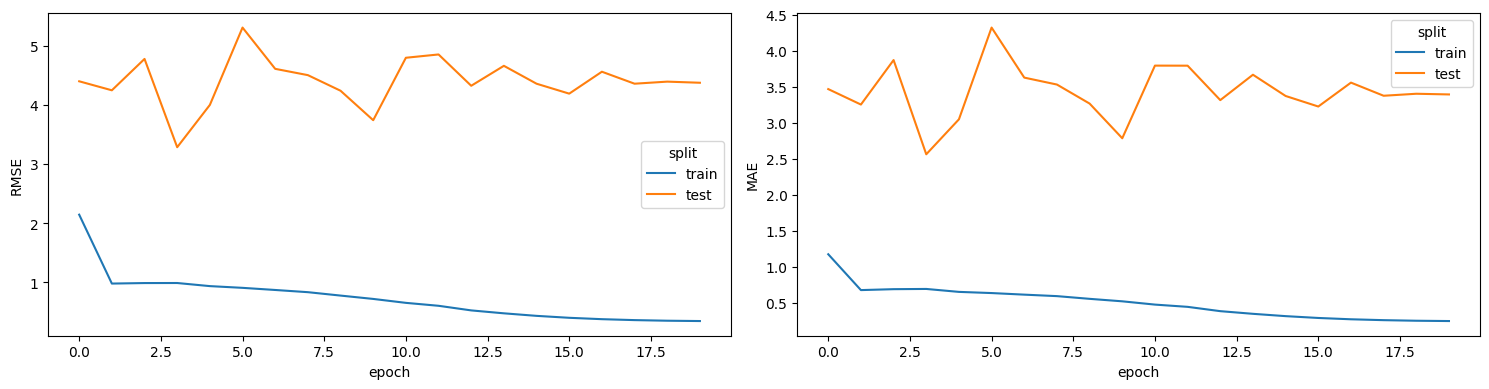

In [ ]:
print('RNN')
rnn_history = fit(
    model            = model_rnn,
    epochs           = epochs,
    trainloader      = trainloader,
    testloader       = validloader,
    criterion        = criterion,
    optimizer        = optimizer_rnn,
    scheduler        = scheduler_rnn,
    forecasting_size = forecasting_size,
    scaler           = y_scaler,
    savedir          = 'saved_model/RNN',
    seed             = seed
)
history_plot(history=rnn_history)

print('LSTM')
lstm_history = fit(
    model            = model_lstm,
    epochs           = epochs,
    trainloader      = trainloader,
    testloader       = testloader,
    criterion        = criterion,
    optimizer        = optimizer_lstm,
    scheduler        = scheduler_lstm,
    forecasting_size = forecasting_size,
    scaler           = y_scaler,
    savedir          = 'saved_model/LSTM',
    seed             = seed
)
history_plot(history=lstm_history)

print('GRU')
gru_history = fit(
    model            = model_gru,
    epochs           = epochs,
    trainloader      = trainloader,
    testloader       = testloader,
    criterion        = criterion,
    optimizer        = optimizer_gru,
    scheduler        = scheduler_gru,
    forecasting_size = forecasting_size,
    scaler           = y_scaler,
    savedir          = 'saved_model/GRU',
    seed             = seed
)
history_plot(history=gru_history)


# Test

In [ ]:
model_rnn.load_state_dict(torch.load('./saved_model/RNN/best_model.pt'))
model_lstm.load_state_dict(torch.load('./saved_model/LSTM/best_model.pt'))
model_gru.load_state_dict(torch.load('./saved_model/GRU/best_model.pt'))

<All keys matched successfully>

<All keys matched successfully>

In [ ]:
# test
rnn_test_results, rnn_preds = test(
    model            = model_rnn,
    testloader       = testloader,
    criterion        = criterion,
    forecasting_size = forecasting_size,
    scaler           = y_scaler,
    return_preds     = True
)

# test
lstm_test_results, lstm_preds = test(
    model            = model_lstm,
    testloader       = testloader,
    criterion        = criterion,
    forecasting_size = forecasting_size,
    scaler           = y_scaler,
    return_preds     = True
)

# test
gru_test_results, gru_preds = test(
    model            = model_gru,
    testloader       = testloader,
    criterion        = criterion,
    forecasting_size = forecasting_size,
    scaler           = y_scaler,
    return_preds     = True
)

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
results = defaultdict(list)

results['Model'] = ['RNN', 'LSTM', 'GRU']
exp_metrics = [rnn_test_results, lstm_test_results, gru_test_results]
for metrics in exp_metrics:
    for k, v in metrics.items():
        results[k].append(v)

table = pd.DataFrame(results)
table

Model      RMSE       MAE
0   RNN  3.830679  2.979555
1  LSTM  3.488635  2.586697
2   GRU  4.372069  3.391176

Model      RMSE       MAE
0   RNN  3.830679  2.979555
1  LSTM  3.488635  2.586697
2   GRU  4.372069  3.391176

Prediction Aggregation

<p align="center">
  <img src="https://github.com/TooTouch/BalancedSoftmax/assets/37654013/02673d54-9884-4826-a323-21b35070703e" width="500">
</p>


In [ ]:
def agg_prediction(preds: np.ndarray):
    len_time, forecasting_size = preds.shape

    agg = np.zeros(len(preds)+(forecasting_size-1))
    cum = np.zeros(len(preds)+(forecasting_size-1))

    for t in range(len_time):
        time_idx = np.arange(forecasting_size) + t

        agg[time_idx] += preds[t]
        cum[time_idx] += 1

    agg /= cum

    return agg

In [ ]:
agg_rnn_preds = agg_prediction(preds=rnn_preds)
agg_lstm_preds = agg_prediction(preds=lstm_preds)
agg_gru_preds = agg_prediction(preds=gru_preds)

In [ ]:
df_test = df.iloc[-(test_len + forecasting_size - 1):]

# add preds
df_test['rnn_pred'] = agg_rnn_preds
df_test['lstm_pred'] = agg_lstm_preds
df_test['gru_pred'] = agg_gru_preds

In [ ]:
results_agg = defaultdict(list)

results_agg['Model'] = ['RNN', 'LSTM', 'GRU']
for m in results_agg['Model']:
    metrics = calc_metrics(y_true=df_test['OT'], y_pred=df_test[f'{m.lower()}_pred'])
    for k, v in metrics.items():
        results_agg[k].append(v)

table_agg = pd.DataFrame(results_agg)
table_agg.columns = ['Model', 'RMSE(agg)', 'MAE(agg)']

In [ ]:
pd.merge(table, table_agg, on="Model", how="inner")

Model      RMSE       MAE  RMSE(agg)  MAE(agg)
0   RNN  3.830679  2.979555   2.888602  2.260990
1  LSTM  3.488635  2.586697   2.813679  2.112109
2   GRU  4.372069  3.391176   3.624068  2.890011

Model      RMSE       MAE  RMSE(agg)  MAE(agg)
0   RNN  3.830679  2.979555   2.888602  2.260990
1  LSTM  3.488635  2.586697   2.813679  2.112109
2   GRU  4.372069  3.391176   3.624068  2.890011

# Figure

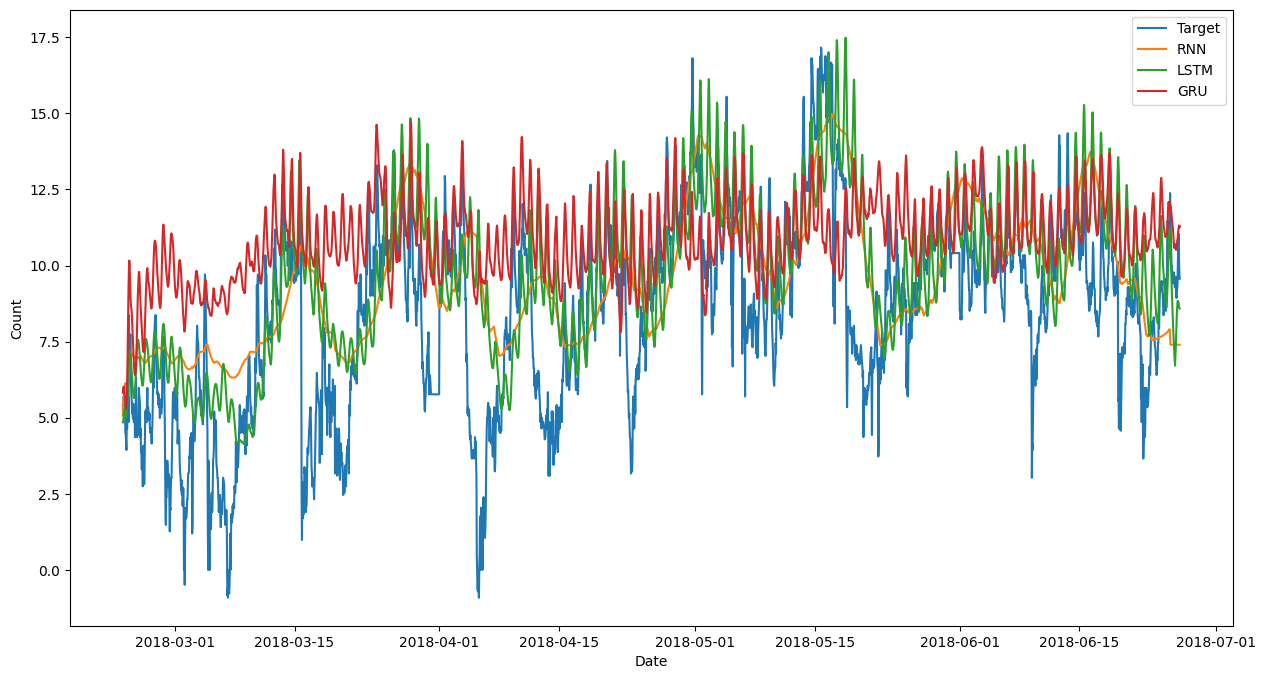

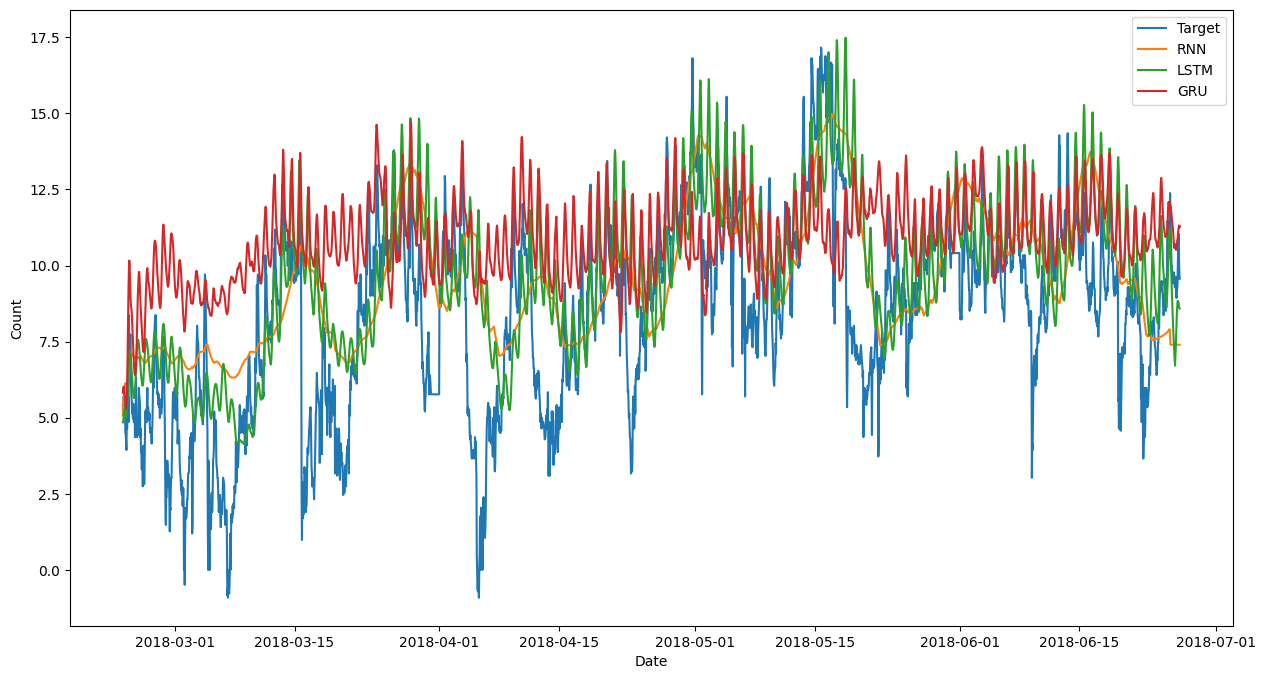

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(x='date', y='OT', data=df_test, label='Target', ax=ax)
sns.lineplot(x='date', y='rnn_pred', data=df_test, label='RNN', ax=ax)
sns.lineplot(x='date', y='lstm_pred', data=df_test, label='LSTM', ax=ax)
sns.lineplot(x='date', y='gru_pred', data=df_test, label='GRU', ax=ax)
ax.set_ylabel('Count')
ax.set_xlabel('Date')
plt.show()

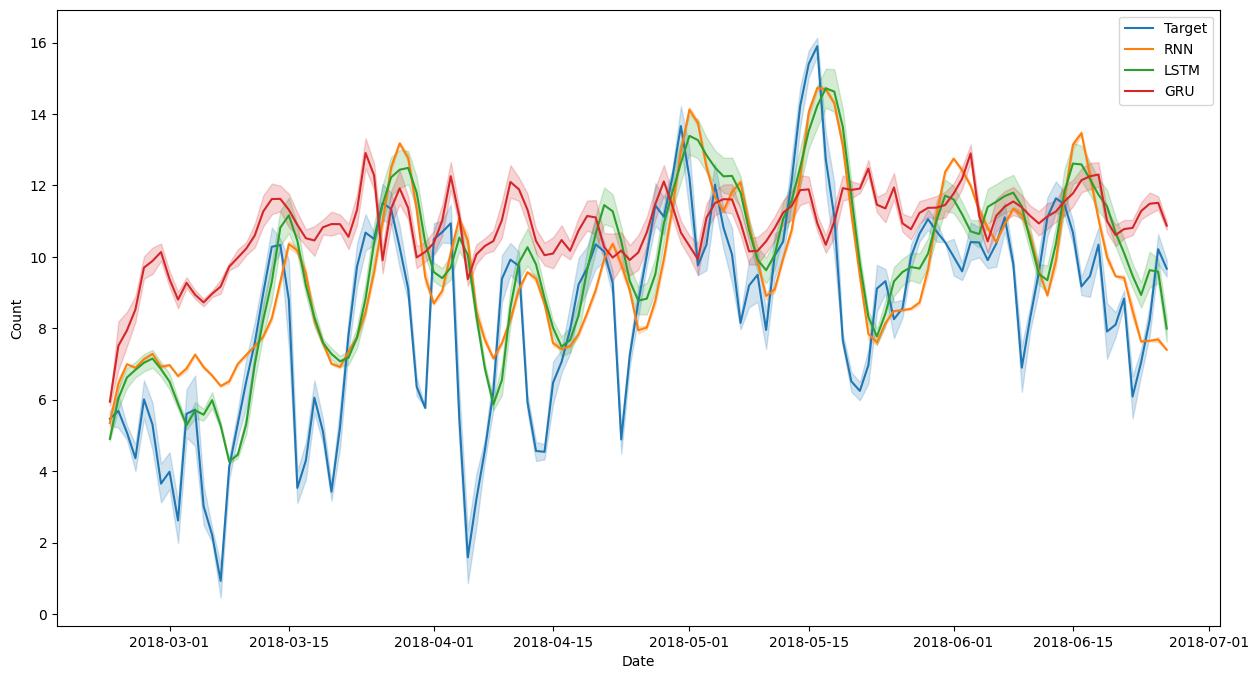

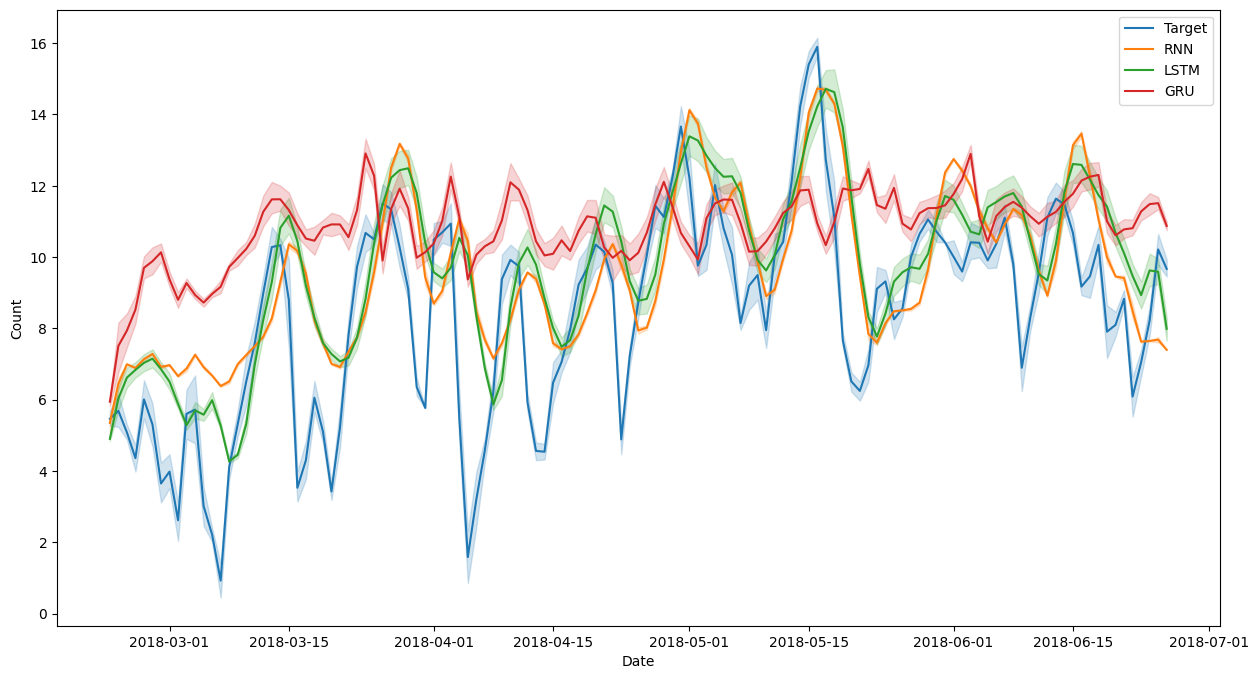

In [ ]:
df_test['date_day'] = df_test['date'].dt.date

fig, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(x='date_day', y='OT', data=df_test, label='Target', ax=ax)
sns.lineplot(x='date_day', y='rnn_pred', data=df_test, label='RNN', ax=ax)
sns.lineplot(x='date_day', y='lstm_pred', data=df_test, label='LSTM', ax=ax)
sns.lineplot(x='date_day', y='gru_pred', data=df_test, label='GRU', ax=ax)
ax.set_ylabel('Count')
ax.set_xlabel('Date')
plt.show()

# Window 수에 따른 성능 변화

In [ ]:
trainset = TSDataset(
    X                = X,
    y                = y,
    window_idx       = train_window_idx,
    window_size      = 32,
    forecasting_size = forecasting_size,
    X_scaler         = X_scaler,
    y_scaler         = y_scaler
)

In [ ]:
def run(
    X,
    y,
    window_size: int,
    forecasting_size: int,
    epochs: int,
    lr: float,
    eta_min: float,
    seed: int
):

    # configuration
    forecasting_size = 24 * 4 # 4 days
    stride = 1
    nb_samples = len(X)
    nb_window = (nb_samples - (window_size + forecasting_size)) + stride

    print('window_size: ',window_size)
    print('forecasting_size: ',forecasting_size)
    print('stride: ',stride)
    print('nb_samples: {:,}'.format(nb_samples))
    print('nb_window: {:,}'.format(nb_window))

    # set window index
    window_idx = np.arange(nb_window)

    # split dataset
    test_len = 24 * 120 # 120 days
    valid_len = 24 * 120 # 120 days

    test_window_idx = window_idx[-test_len:]
    valid_window_idx = window_idx[-(test_len + valid_len):-test_len]
    train_window_idx = window_idx[:-(test_len + valid_len)]

    print('train_window_idx.shape: ', train_window_idx.shape)
    print('valid_window_idx.shape: ', valid_window_idx.shape)
    print('test_window_idx.shape: ', test_window_idx.shape)

    # fit scaler
    X_scaler = StandardScaler()
    X_scaler.fit(X[:-(valid_len+test_len)])

    y_scaler = StandardScaler()
    y_scaler.fit(y[:-(valid_len+test_len)].reshape(-1,1))

    # make datasets
    trainset = TSDataset(
        X                = X,
        y                = y,
        window_idx       = train_window_idx,
        window_size      = window_size,
        forecasting_size = forecasting_size,
        X_scaler         = X_scaler,
        y_scaler         = y_scaler
    )

    validset = TSDataset(
        X                = X,
        y                = y,
        window_idx       = valid_window_idx,
        window_size      = window_size,
        forecasting_size = forecasting_size,
        X_scaler         = X_scaler,
        y_scaler         = y_scaler
    )

    testset = TSDataset(
        X                = X,
        y                = y,
        window_idx       = test_window_idx,
        window_size      = window_size,
        forecasting_size = forecasting_size,
        X_scaler         = X_scaler,
        y_scaler         = y_scaler
    )

    # make dataloaders
    trainloader = DataLoader(
        dataset     = trainset,
        batch_size  = 128,
        shuffle     = True,
    )

    validloader = DataLoader(
        dataset     = validset,
        batch_size  = 1024,
        shuffle     = False,
    )

    testloader = DataLoader(
        dataset     = testset,
        batch_size  = 1024,
        shuffle     = False,
    )

    # Instantiate the LSTM model
    torch_seed(223)
    model = VanillaModel(module_type='LSTM', input_dim=X.shape[1]+1, hidden_dim=256, num_layers=2)
    print('LSTM parameters: {:,}'.format(sum([p.numel() for p in model.parameters()])))

    model.cuda()
    print('convert device to GPU')

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=eta_min)

    # loss function
    criterion = nn.MSELoss()

    # training
    print('LSTM')
    history = fit(
        model            = model,
        epochs           = epochs,
        trainloader      = trainloader,
        testloader       = validloader,
        criterion        = criterion,
        optimizer        = optimizer,
        scheduler        = scheduler,
        forecasting_size = forecasting_size,
        scaler           = y_scaler,
        savedir          = f'saved_model/LSTM-w{window_size}',
        seed             = 223
    )
    history_plot(history=history)

    # test
    model.load_state_dict(torch.load(f'./saved_model/LSTM-w{window_size}/best_model.pt'))
    test_results, preds = test(
        model            = model,
        testloader       = testloader,
        criterion        = criterion,
        forecasting_size = forecasting_size,
        scaler           = y_scaler,
        return_preds     = True
    )

    return test_results, preds

In [ ]:
window_size = [32, 64, 96]
forecasting_size = 96
epochs = 20
lr = 1e-2
eta_min = lr * 1e-2
seed = 223


[Window Size = 32]
window_size:  32
forecasting_size:  96
stride:  1
nb_samples: 17,420
nb_window: 17,293
train_window_idx.shape:  (11533,)
valid_window_idx.shape:  (2880,)
test_window_idx.shape:  (2880,)
LSTM parameters: 1,589,505
convert device to GPU
LSTM


  0%|          | 0/20 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

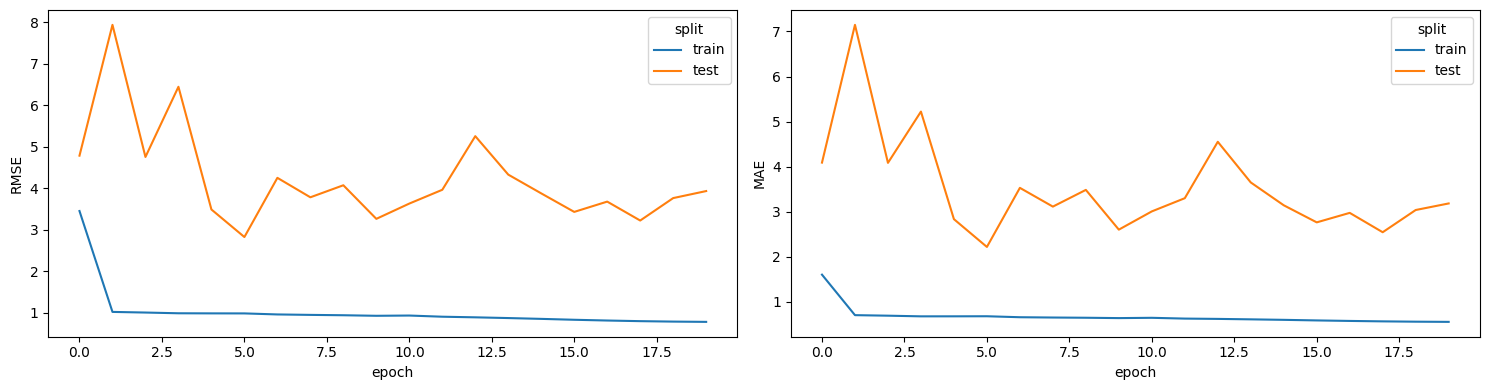

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]


[Window Size = 64]
window_size:  64
forecasting_size:  96
stride:  1
nb_samples: 17,420
nb_window: 17,261
train_window_idx.shape:  (11501,)
valid_window_idx.shape:  (2880,)
test_window_idx.shape:  (2880,)
LSTM parameters: 1,589,505
convert device to GPU
LSTM


  0%|          | 0/20 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

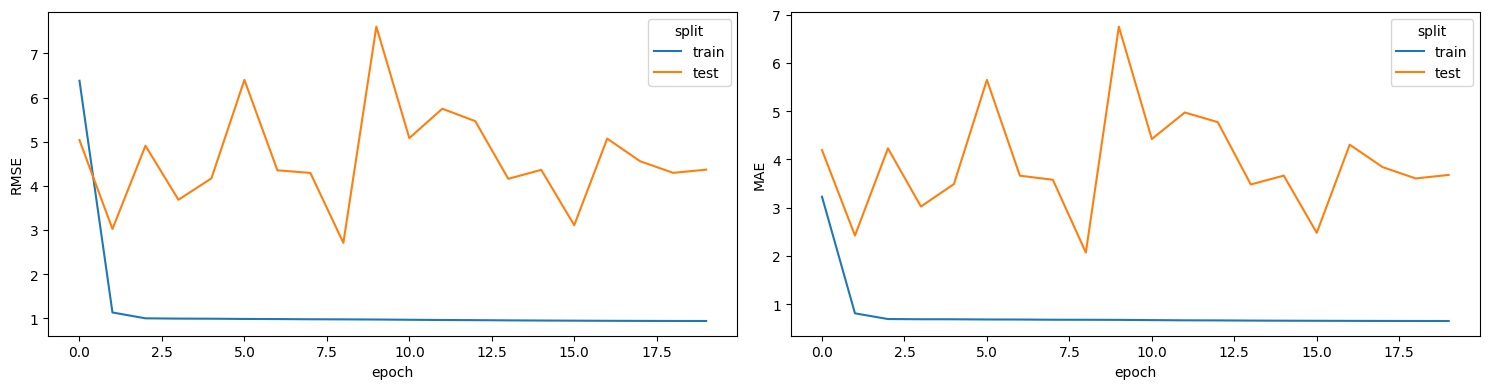

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]


[Window Size = 96]
window_size:  96
forecasting_size:  96
stride:  1
nb_samples: 17,420
nb_window: 17,229
train_window_idx.shape:  (11469,)
valid_window_idx.shape:  (2880,)
test_window_idx.shape:  (2880,)
LSTM parameters: 1,589,505
convert device to GPU
LSTM


  0%|          | 0/20 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

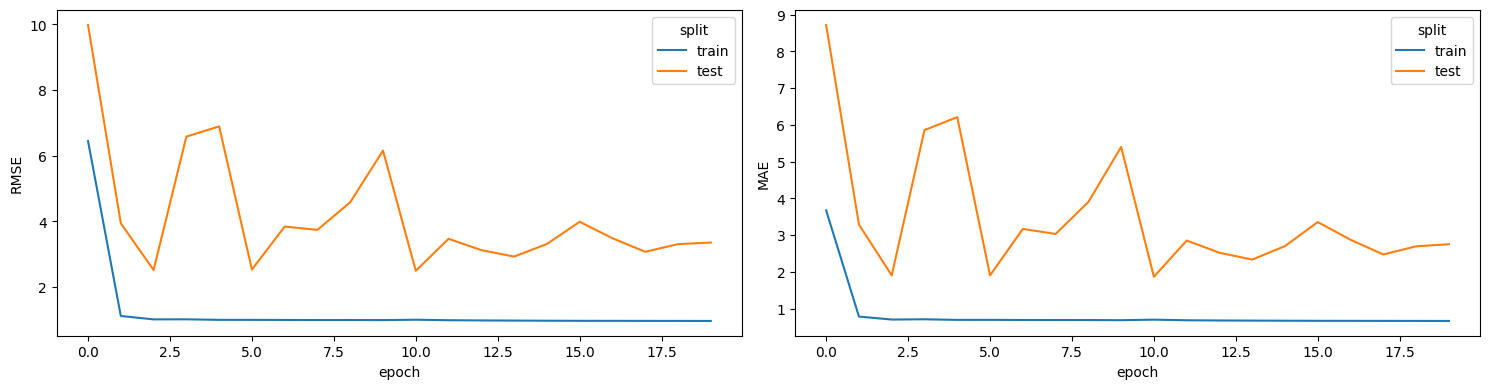

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]


[Window Size = 32]
window_size:  32
forecasting_size:  96
stride:  1
nb_samples: 17,420
nb_window: 17,293
train_window_idx.shape:  (11533,)
valid_window_idx.shape:  (2880,)
test_window_idx.shape:  (2880,)
LSTM parameters: 1,589,505
convert device to GPU
LSTM


  0%|          | 0/20 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/91 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

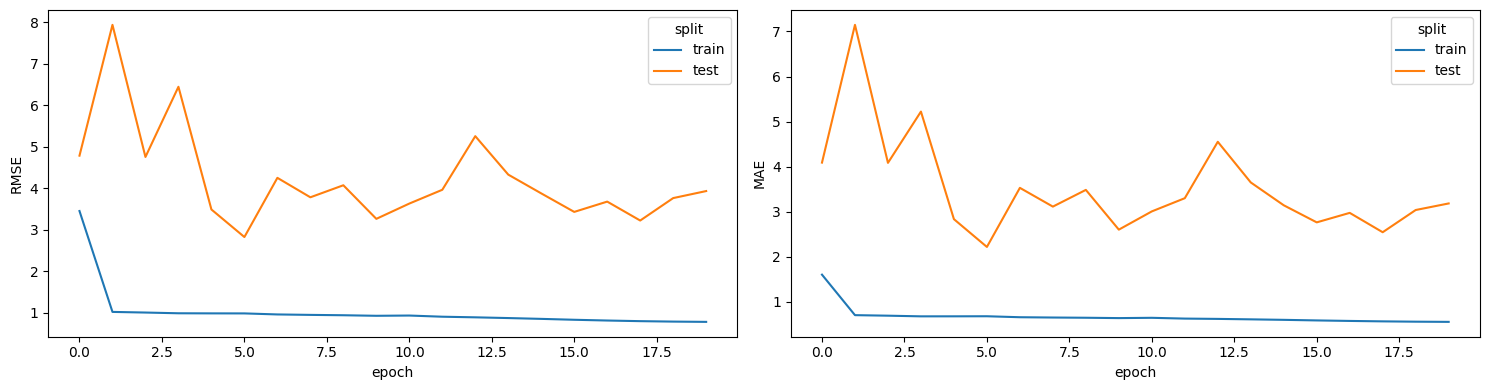

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]


[Window Size = 64]
window_size:  64
forecasting_size:  96
stride:  1
nb_samples: 17,420
nb_window: 17,261
train_window_idx.shape:  (11501,)
valid_window_idx.shape:  (2880,)
test_window_idx.shape:  (2880,)
LSTM parameters: 1,589,505
convert device to GPU
LSTM


  0%|          | 0/20 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

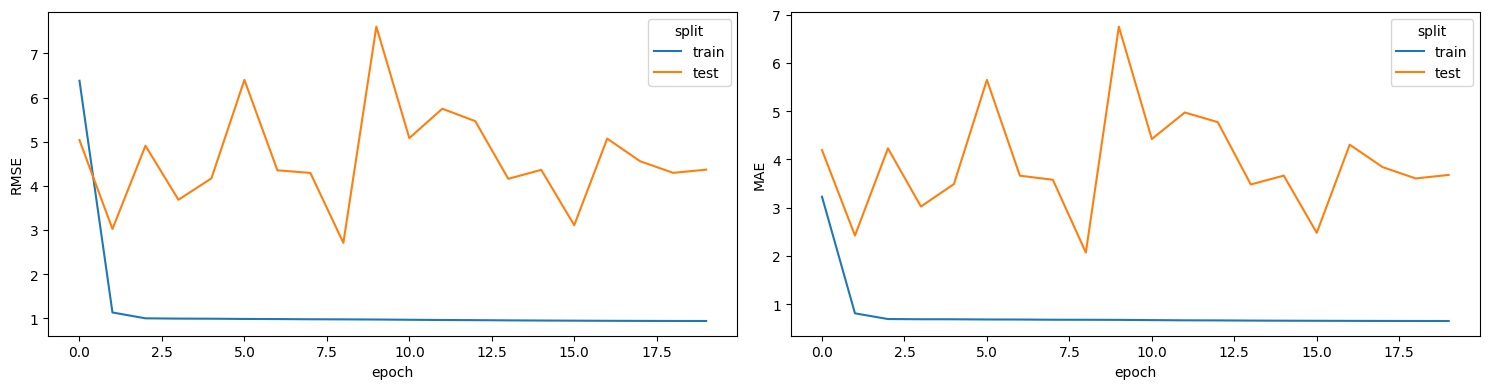

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]


[Window Size = 96]
window_size:  96
forecasting_size:  96
stride:  1
nb_samples: 17,420
nb_window: 17,229
train_window_idx.shape:  (11469,)
valid_window_idx.shape:  (2880,)
test_window_idx.shape:  (2880,)
LSTM parameters: 1,589,505
convert device to GPU
LSTM


  0%|          | 0/20 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

[TRAIN]:   0%|          | 0/90 [00:00<?, ?it/s]

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

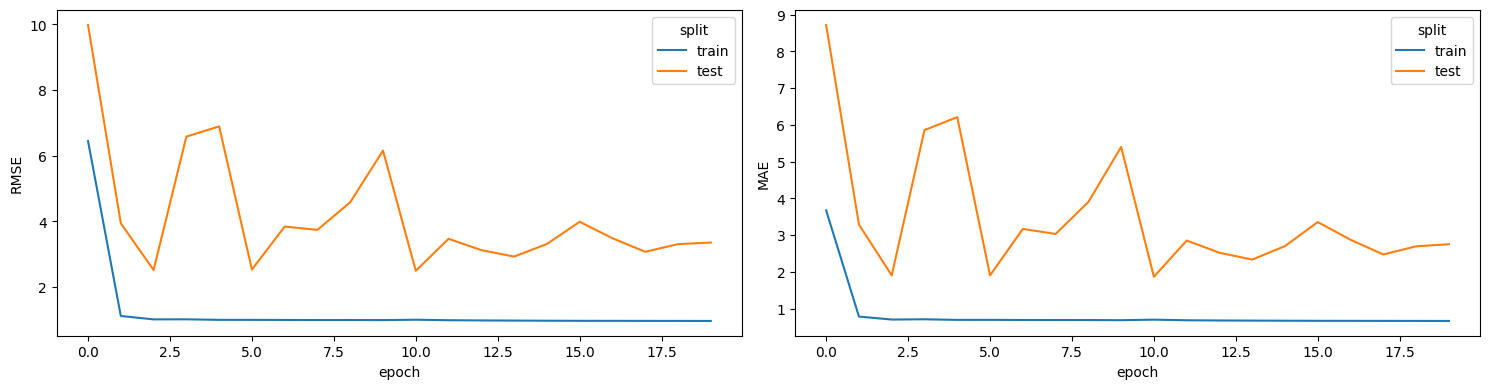

[TEST]:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
ws_results = defaultdict(dict)
for ws in window_size:
    print(f'\n[Window Size = {ws}]')
    test_results_ws, preds_ws = run(
        X                = X,
        y                = y,
        window_size      = ws,
        forecasting_size = forecasting_size,
        epochs           = epochs,
        lr               = lr,
        eta_min          = eta_min,
        seed             = seed
    )

    ws_results[f'ws{ws}']['test_results'] = test_results_ws
    ws_results[f'ws{ws}']['preds'] = preds_ws

In [ ]:
results = defaultdict(list)

results['window size'] = window_size
for ws in window_size:
    for k, v in ws_results[f'ws{ws}']['test_results'].items():
        results[k].append(v)

table = pd.DataFrame(results)
table

window size      RMSE       MAE
0           32  3.227909  2.332448
1           64  4.020472  3.050560
2           96  2.967401  2.308518

window size      RMSE       MAE
0           32  3.227909  2.332448
1           64  4.020472  3.050560
2           96  2.967401  2.308518